In [ ]:
import gdown
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pprint
import random
import pandas as pd
import pulp
import itertools
import requests
import random
from geopy.distance import geodesic
import time
import pandas as pd
import os

Downloading...
From (original): https://drive.google.com/uc?id=1zq17RENYLU1qrE2gNPsxRAPoysWMZAqf
From (redirected): https://drive.google.com/uc?id=1zq17RENYLU1qrE2gNPsxRAPoysWMZAqf&confirm=t&uuid=ef22bbac-40ad-4d82-8da6-ea0057970dc6
To: /content/mpsis_setup.py
100%|██████████| 12.1k/12.1k [00:00<00:00, 10.2MB/s]


Mounted at /content/drive


In [ ]:
def generate_random_point(sw_lat, sw_lng, ne_lat, ne_lng):
    lat = random.uniform(sw_lat, ne_lat)
    lng = random.uniform(sw_lng, ne_lng)
    return lat, lng

def snap_to_road(lat, lng, api_key):
    url = f'https://roads.googleapis.com/v1/nearestRoads?points={lat},{lng}&key={api_key}'
    response = requests.get(url)
    data = response.json()
    if 'snappedPoints' in data and len(data['snappedPoints']) > 0:
        snapped_point = data['snappedPoints'][0]['location']
        return snapped_point['latitude'], snapped_point['longitude']
    return None

def get_road_distance_time(origin, destination, api_key):
    origin_str = f'{origin[0]}, {origin[1]}'
    destination_str = f'{destination[0]}, {destination[1]}'
    departure_time = int(time.time()) + 24 * 3600
    url = (
        f'https://maps.googleapis.com/maps/api/distancematrix/json?units=metric&origins={origin_str}'
        f'&destinations={destination_str}&mode=driving&departure_time={departure_time}&key={api_key}'
    )
    response = requests.get(url)
    data = response.json()

    if data['status'] == 'OK':
        element = data['rows'][0]['elements'][0]
        if element['status'] == 'OK':
            distance_text = element['distance']['text']
            distance = float(distance_text.replace(' km', '').replace(',', ''))

            duration_text = element['duration']['text']
            duration_parts = duration_text.split()
            duration = int(duration_parts[0])
            if "hour" in duration_text:
                duration = int(duration_parts[0]) * 60 + int(duration_parts[2])

            return distance, duration
        else:
            return None, None
    else:
        return None, None

def find_center(sw_lat, sw_lng, ne_lat, ne_lng):
    center_lat = (sw_lat + ne_lat) / 2
    center_lng = (sw_lng + ne_lng) / 2
    return center_lat, center_lng

def generate_list(n, target_sum):
    if n <= 1:
        raise ValueError("The length of the list must be greater than 1.")
    if target_sum < 0:
        raise ValueError("The target sum must be non-negative.")
    result = [0]
    random_values = np.random.rand(n - 1)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    result.extend(rounded_values)

    return result

def crop_matrix(data, N):
    return [row[:N] for row in data[:N]]

import numpy as np

def generate_demand_list(n, m, target_sum):
    if n <= 1:
        raise ValueError("The length of the list must be greater than 1.")
    if m >= n:
        raise ValueError("M must be less than N.")
    if target_sum < 0:
        raise ValueError("The target sum must be non-negative.")

    random_values = np.random.rand(n - m - 1)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    zeros_list = [0] * m

    result = list(rounded_values) + zeros_list

    random.shuffle(result)

    result = [-1] + result

    return result
def replace_zeros_with_sum(input_list, target_sum):
    zero_positions = [i for i, value in enumerate(input_list) if value == 0]
    num_zeros = len(zero_positions)

    result = input_list.copy()

    if num_zeros == 0:
        raise ValueError("There are no zeros to replace in the list.")

    random_values = np.random.rand(num_zeros)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    for i, pos in enumerate(zero_positions):
        result[pos] = rounded_values[i]

    return result

def create_path_as_list(pairs_list):
    wanted_length = len(pairs_list)
    path = ''
    current_pair = next(pair for pair in pairs_list if pair[0] == 0)
    path += str(current_pair[0])

    next_start = current_pair[1]

    pairs_list.remove(current_pair)

    while len(path) < wanted_length:
        path += str(next_start)
        current_pair = next(pair for pair in pairs_list if pair[0] == next_start)
        pairs_list.remove(current_pair)
        next_start = current_pair[1]

    return path

def find_paths_vrb(edges, k):
    def find_path_vrb(current_path):
        if len(paths) >= k:
            return

        last_node = current_path[-1]

        if last_node == 0 and len(current_path) > 1:
            paths.append(current_path)
            return

        for edge in edges:
            if edge[0] == last_node:
                find_path_vrb(current_path + [edge[1]])

    paths = []
    find_path_vrb([0])

    return paths

def repetitions(list1, list2):
  common_elements = set(list1) & set(list2)
  return (2*len(common_elements))/len(list1+list2)

def equal_paths(list1, list2):
  are_equal = sorted(list1) == sorted(list2)
  if are_equal:
    return 1
  else:
    return 0

In [ ]:
def create_cost_matrixes(df):
    real_distance_columns = [col for col in df.columns if col.startswith('Road Distance to Point')]
    df_filtered = df[real_distance_columns]

    num_points = len(df_filtered)
    cost_raod = [[0] * num_points for _ in range(num_points)]

    for i in range(num_points):
        for j in range(num_points):
            if i != j:
                column_name = f'Road Distance to Point {j + 1}'
                distance = df_filtered.iloc[i][column_name]

                cost_raod[i][j] = float(distance)


    real_distance_columns = [col for col in df.columns if col.startswith('Time to Point')]
    df_filtered = df[real_distance_columns]

    num_points = len(df_filtered)
    cost_time = [[0] * num_points for _ in range(num_points)]

    for i in range(num_points):
        for j in range(num_points):
            if i != j:
                column_name = f'Time to Point {j + 1}'
                distance = df_filtered.iloc[i][column_name]

                cost_time[i][j] = float(distance)


    real_distance_columns = [col for col in df.columns if col.startswith('Real Distance to Point')]
    df_filtered = df[real_distance_columns]

    num_points = len(df_filtered)
    cost_real = [[0] * num_points for _ in range(num_points)]

    for i in range(num_points):
        for j in range(num_points):
            if i != j:
                column_name = f'Real Distance to Point {j + 1}'
                distance = df_filtered.iloc[i][column_name]

                cost_real[i][j] = float(distance)

    return cost_raod, cost_time, cost_real

In [ ]:
def find_paths_vrb(edges, k, depot_one_more_time):
    def find_path_vrb(current_path):
        if len(paths) >= k:
            return

        last_node = current_path[-1]

        if last_node == depot_one_more_time and len(current_path) > 1:
            paths.append(current_path)
            return

        for edge in edges:
            if edge[0] == last_node:
                find_path_vrb(current_path + [edge[1]])

    paths = []
    find_path_vrb([0])
    return paths

def vrptw(number_of_clients, number_of_vehicles, cost_buffor, a, b, t, T,  file_idx, problem_idx):
    try:
      n = number_of_clients
      c = number_of_vehicles
      Q = 100
      M = 10000000

      cost_shiffted = crop_matrix(cost_buffor,n+1)
      cost_shiffted.append(cost_shiffted[0])
      iterator = 0
      for row in cost_shiffted:
        cost_shiffted[iterator].append(cost_shiffted[iterator][0])
        iterator += 1

      prob = pulp.LpProblem("VRPTW", pulp.LpMinimize)

      x = pulp.LpVariable.dicts("x", [(i,j,k) for i in range(n+1) for j in range(1, n+2) for k in range(c)], cat='Binary')
      s = pulp.LpVariable.dicts("s", [(i,k) for i in range(n+2) for k in range(c)], lowBound=0, cat='Continuous')

      prob += pulp.lpSum(cost_shiffted[i][j] * x[(i,j,k)] for i in range(n+1) for j in range(1, n+2) for k in range(c))

      for j in range(1, n+1):
          prob += pulp.lpSum(x[(i,j,k)] for i in range(n+1) for k in range(c)) == 1

      for i in range(1, n+1):
          prob += pulp.lpSum(x[(i,j,k)] for j in range(1, n+2) for k in range(c)) == 1

      for k in range(c):
          prob += pulp.lpSum(x[i,n+1,k] for i in range(n+1)) == 1

      for k in range(c):
          prob += pulp.lpSum(x[0,j,k] for j in range(1, n+2)) == 1

      for m in range(1, n+1):
        for k in range(c):
          prob += pulp.lpSum(x[(i,m,k)] for i in range(n+1) if i != m) == pulp.lpSum(x[(m,j,k)] for j in range(1,n+2) if j != m)

      for k in range(c):
        prob += x[0,n+1,k] == 0

      for i in range(n+1):
        for j in range(1,n+2):
          for k in range(c):
            if i == j:
              prob += x[(i,j,k)] == 0

      for i in range(n+1):
        for j in range(1,n+2):
          for k in range(c):
            prob += s[(i,k)] + t[i] + T[i][j] <= s[(j,k)] + M*(1 - x[(i,j,k)])

      for i in range(1, n+1):
        for k in range(c):
          prob += M*(pulp.lpSum(x[i,j,k] for j in range(1,n+2)) - 1) + a[i] <= s[(i,k)]

      for i in range(1, n+1):
        for k in range(c):
          prob += s[(i,k)] + t[i] <= b[i] + M*(1 - pulp.lpSum(x[(i,j,k)] for j in range(1,n+2)))

      prob.solve()

      print(pulp.value(prob.objective))

      all_uesd_edges = []
      paths = [[] for _ in range(c)]

      for k in range(c):
          for i in range(n + 1):
              for j in range(1, n + 2):
                  if i != j and pulp.value(x[i,j,k]) == 1:
                      all_uesd_edges.append((i, j))
                      paths[k].append((i, j))

      result_paths = find_paths_vrb(all_uesd_edges, number_of_clients, number_of_clients+1)
      return pulp.value(prob.objective), result_paths, all_uesd_edges

    except Exception as e:
        print(f"error for delivery stops {number_of_clients} and vehicles {number_of_vehicles}")

        values_to_reload.append((number_of_clients, number_of_vehicles, file_idx, problem_idx))

        return None, None, None

def vrptw_error(number_of_clients, number_of_vehicles, cost_buffor, a, b, t, T, file_idx):
  try:
      n = number_of_clients
      c = number_of_vehicles
      Q = 100
      M = 10000000

      cost_shiffted = crop_matrix(cost_buffor,n+1)
      cost_shiffted.append(cost_shiffted[0])
      iterator = 0
      for row in cost_shiffted:
        cost_shiffted[iterator].append(cost_shiffted[iterator][0])
        iterator += 1

      prob = pulp.LpProblem("VRPTW", pulp.LpMinimize)

      x = pulp.LpVariable.dicts("x", [(i,j,k) for i in range(n+1) for j in range(1, n+2) for k in range(c)], cat='Binary')
      s = pulp.LpVariable.dicts("s", [(i,k) for i in range(n+2) for k in range(c)], lowBound=0, cat='Continuous')

      prob += pulp.lpSum(cost_shiffted[i][j] * x[(i,j,k)] for i in range(n+1) for j in range(1, n+2) for k in range(c))

      for j in range(1, n+1):
          prob += pulp.lpSum(x[(i,j,k)] for i in range(n+1) for k in range(c)) == 1

      for i in range(1, n+1):
          prob += pulp.lpSum(x[(i,j,k)] for j in range(1, n+2) for k in range(c)) == 1

      for k in range(c):
          prob += pulp.lpSum(x[i,n+1,k] for i in range(n+1)) == 1

      for k in range(c):
          prob += pulp.lpSum(x[0,j,k] for j in range(1, n+2)) == 1

      for m in range(1, n+1):
        for k in range(c):
          prob += pulp.lpSum(x[(i,m,k)] for i in range(n+1) if i != m) == pulp.lpSum(x[(m,j,k)] for j in range(1,n+2) if j != m)

      for k in range(c):
        prob += x[0,n+1,k] == 0

      for i in range(n+1):
        for j in range(1,n+2):
          for k in range(c):
            if i == j:
              prob += x[(i,j,k)] == 0

      for i in range(n+1):
        for j in range(1,n+2):
          for k in range(c):
            prob += s[(i,k)] + t[i] + T[i][j] <= s[(j,k)] + M*(1 - x[(i,j,k)])

      for i in range(1, n+1):
        for k in range(c):
          prob += M*(pulp.lpSum(x[i,j,k] for j in range(1,n+2)) - 1) + a[i] <= s[(i,k)]

      for i in range(1, n+1):
        for k in range(c):
          prob += s[(i,k)] + t[i] <= b[i] + M*(1 - pulp.lpSum(x[(i,j,k)] for j in range(1,n+2)))

      prob.solve()

      print(pulp.value(prob.objective))

      all_uesd_edges = []
      paths = [[] for _ in range(c)]

      for k in range(c):
          for i in range(n + 1):
              for j in range(1, n + 2):
                  if i != j and pulp.value(x[i,j,k]) == 1:
                      all_uesd_edges.append((i, j))
                      paths[k].append((i, j))

      result = find_paths_vrb(all_uesd_edges, number_of_clients, number_of_clients+1)
      return pulp.value(vrpsdp.objective), result_paths, all_uesd_edges

  except Exception as e:
      print(f"ONE MORE TIME ERROR")
      return None, None, None

In [ ]:
import math
import pandas as pd
import os
service_time = 5
number_of_clients = 10
number_of_vehicles = 2
output_dir = 'X'
df = pd.read_csv(os.path.join(output_dir, "X"))
df.fillna(10000000, inplace=True)
cost_R, cost_T, cost_G = create_cost_matrixes(df)

T = crop_matrix(cost_T,number_of_clients+1)
median = np.median(T)
max_time = math.floor(number_of_clients * median + service_time*number_of_clients/number_of_vehicles) +1

time_window_time_list = list(range(50,2701,50))

t = [service_time] * (number_of_clients + 10)
a = [0] * (number_of_clients + 1)
b = [max_time] * (number_of_clients + 1)


number_of_trials = 20
time_window_time_list = list(range(50,2701,50))

cost =  [[]  for _ in time_window_time_list]

for iterator in range(number_of_trials):
  print(f"######################################### Number of trial {iterator}")

  for client in range(number_of_clients + 1):
      a[client] = random.randint(int(median/2), int(max_time - service_time - median))

  for time_window_time in time_window_time_list:
      print(f"time window value {time_window_time}")

      for client in range(number_of_clients + 1):
        b[client] = a[client] + time_window_time


      obj = vrptw(number_of_clients, number_of_vehicles, cost_R, a, b, t, T)

      cost[time_window_time_list.index(time_window_time)].append(obj)

######################################### Number of trial 0
time window value 50
IINFEASEBLE
time window value 100
IINFEASEBLE
time window value 150
IINFEASEBLE
time window value 200
time window value 250
time window value 300
time window value 350
time window value 400
time window value 450
time window value 500
time window value 550
time window value 600
time window value 650
time window value 700
time window value 750
time window value 800
time window value 850
time window value 900
time window value 950
time window value 1000
time window value 1050
time window value 1100
time window value 1150
time window value 1200
time window value 1250
time window value 1300
time window value 1350
time window value 1400
time window value 1450
time window value 1500
time window value 1550
time window value 1600
time window value 1650
time window value 1700
time window value 1750
time window value 1800
time window value 1850
time window value 1900
time window value 1950
time window value 2000
time

In [ ]:
cost = [['INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE'], ['INFEISABLE', 6988.2, 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE'], [6118.0, 8458.0, 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 7534.0, 'INFEISABLE'], [6118.0, 6964.2, 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 7929.0, 6308.2, 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 7125.0, 'INFEISABLE', 'INFEISABLE', 7510.0, 'INFEISABLE'], [6118.0, 'INFEISABLE', 'INFEISABLE', 8041.2, 8730.2, 6803.0, 'INFEISABLE', 'INFEISABLE', 7472.0, 'INFEISABLE', 6308.2, 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 8274.0, 'INFEISABLE', 'INFEISABLE', 7395.2, 'INFEISABLE'], [6222.0, 7264.2, 'INFEISABLE', 7732.2, 7344.2, 6635.0, 7569.0, 'INFEISABLE', 'INFEISABLE', 7871.0, 6308.2, 'INFEISABLE', 7766.2, 6674.0, 'INFEISABLE', 7169.0, 'INFEISABLE', 6679.0, 7713.2, 'INFEISABLE'], [7119.0, 6674.2, 6824.0, 'INFEISABLE', 7344.2, 7824.0, 6929.2, 7705.0, 6403.2, 7812.0, 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 'INFEISABLE', 7317.2, 'INFEISABLE', 7686.2, 6393.0, 7369.0, 6614.0], [6323.0, 6829.2, 6729.2, 7732.2, 7344.2, 6635.0, 6929.2, 7000.0, 6403.2, 'INFEISABLE', 6308.2, 6886.2, 8440.0, 6674.0, 6755.2, 7841.0, 8147.0, 6896.0, 7013.2, 8424.0], [6181.0, 6805.2, 6729.2, 7679.0, 7385.0, 6519.0, 6330.2, 7000.0, 'INFEISABLE', 7361.0, 7844.2, 6751.2, 7153.2, 6397.0, 'INFEISABLE', 8054.0, 6965.2, 'INFEISABLE', 6674.2, 7759.0], [6077.0, 6674.2, 6824.0, 7394.2, 7385.0, 6119.0, 6330.2, 6462.0, 'INFEISABLE', 7342.0, 6308.2, 'INFEISABLE', 7153.2, 6397.0, 'INFEISABLE', 6838.0, 7344.2, 'INFEISABLE', 6516.2, 6473.2], [6077.0, 6674.2, 6720.2, 7316.0, 6857.2, 6119.0, 6310.0, 6462.0, 6403.2, 7293.0, 6746.2, 6557.2, 7153.2, 6397.0, 7078.0, 6422.0, 6965.2, 6213.2, 6492.2, 6384.0], [6476.0, 6674.2, 'INFEISABLE', 6583.2, 7713.2, 6223.0, 6673.0, 6595.0, 6738.2, 7115.2, 6308.2, 7016.2, 6494.2, 6397.0, 7206.2, 7121.0, 6549.2, 6213.2, 6516.2, 6243.2], [6118.0, 6805.2, 6525.2, 6709.2, 6952.0, 6119.0, 6330.2, 6592.0, 6403.2, 7115.2, 6308.2, 6557.2, 6589.0, 6761.0, 6755.2, 6048.0, 6549.2, 6393.0, 6492.2, 6243.2], [6077.0, 6698.2, 6513.2, 7081.2, 6857.2, 6146.2, 6310.0, 6806.2, 6362.2, 6664.0, 6507.2, 5928.2, 7372.0, 6397.0, 7206.2, 6048.0, 6175.2, 6213.2, 6275.2, 6382.0], [6282.0, 7619.2, 6581.2, 6349.2, 6173.2, 6102.0, 6310.0, 6700.0, 6674.2, 6664.0, 6448.2, 6122.2, 6494.2, 6830.0, 6780.2, 6048.0, 6175.2, 6233.2, 6070.2, 6382.0], [6077.0, 6932.2, 6513.2, 5950.2, 6173.2, 6102.0, 6083.0, 6595.0, 6779.2, 7009.0, 7048.2, 5928.2, 6262.2, 6397.0, 6853.2, 6048.0, 6175.2, 6220.0, 6243.2, 6473.2], [6504.2, 6674.2, 6513.2, 5950.2, 6173.2, 6146.2, 6083.0, 6402.2, 6362.2, 6506.0, 6368.0, 5928.2, 6262.2, 6238.0, 6755.2, 6048.0, 6175.2, 5921.2, 6070.2, 6382.0], [6077.0, 7281.2, 6513.2, 6373.0, 6589.2, 6102.0, 6182.2, 6403.0, 6362.2, 6506.0, 6208.2, 5928.2, 6262.2, 6519.0, 6773.2, 6048.0, 6192.2, 6169.0, 6389.0, 6326.2], [6077.0, 6789.2, 6197.2, 6373.0, 6446.0, 6102.0, 6083.0, 6402.2, 6362.2, 6335.0, 6308.2, 5945.2, 6262.2, 6602.0, 6828.2, 6048.0, 6175.2, 6672.0, 6102.2, 6933.2], [6077.0, 6817.2, 6197.2, 6090.2, 6277.2, 6488.0, 8373.0, 6402.2, 6403.2, 6048.0, 6208.2, 5928.2, 6489.2, 6238.0, 6780.2, 6341.2, 6175.2, 5901.2, 6060.2, 6226.2], [6077.0, 6814.0, 6197.2, 5950.2, 6162.2, 6102.0, 6083.0, 6144.0, 6132.2, 6048.0, 6208.2, 5945.2, 6262.2, 6602.0, 6773.2, 6763.0, 6192.2, 5901.2, 6060.2, 6365.0], [6077.0, 6302.2, 6111.2, 5950.2, 6162.2, 6146.2, 6310.0, 6144.0, 6157.2, 6060.2, 6208.2, 5928.2, 6182.2, 6238.0, 6737.2, 6065.0, 6175.2, 5921.2, 6058.0, 6243.2], [6077.0, 6326.2, 6010.2, 5950.2, 6173.2, 6488.0, 6182.2, 6819.0, 6119.2, 6048.0, 6332.0, 5928.2, 6182.2, 6058.0, 6737.2, 6060.2, 6314.0, 6213.2, 6048.0, 6313.2], [6119.0, 6458.2, 5895.2, 5950.2, 6173.2, 6414.0, 6083.0, 6930.0, 5938.2, 6048.0, 6191.2, 5928.2, 6182.2, 6058.0, 6825.2, 6065.0, 6192.2, 5921.2, 6048.0, 5914.2], [6077.0, 6302.2, 5878.2, 6300.2, 6198.2, 6119.0, 6182.2, 6582.0, 5938.2, 6155.0, 6191.2, 5928.2, 6403.2, 6058.0, 6773.2, 6048.0, 6182.0, 5901.2, 6048.0, 6206.0], [6146.2, 6326.2, 5878.2, 5950.2, 6162.2, 6163.2, 6083.0, 6144.0, 5938.2, 6102.2, 6191.2, 5928.2, 6198.2, 6058.0, 6800.2, 6077.2, 6192.0, 5921.2, 6048.0, 6073.2], [6077.0, 6302.2, 5878.2, 5950.2, 6198.2, 6102.0, 6330.2, 6412.0, 5938.2, 6048.0, 6191.2, 6263.2, 6174.2, 6211.0, 6737.2, 6048.0, 6060.2, 5901.2, 5990.0, 6073.2], [6077.0, 6326.2, 5895.2, 5950.2, 6578.2, 6102.0, 6083.0, 6144.0, 5938.2, 6060.2, 6191.2, 5928.2, 5938.2, 6237.2, 7417.2, 6065.0, 6060.2, 5879.2, 5895.2, 5914.2], [6118.0, 6326.2, 5878.2, 5950.2, 6842.2, 6532.2, 6083.0, 6540.2, 5938.2, 6048.0, 6501.0, 6629.2, 5938.2, 6237.2, 6818.2, 6048.0, 6060.2, 5879.2, 5895.2, 5931.2], [6077.0, 5945.2, 5840.2, 5950.2, 6198.2, 6102.0, 5963.2, 6582.0, 5938.2, 6060.2, 6208.2, 5928.2, 5963.2, 6076.2, 6128.2, 6065.0, 6060.2, 5879.2, 6009.2, 5914.2], [6073.2, 5945.2, 5857.2, 5950.2, 6198.2, 6567.0, 6190.2, 6127.0, 5980.2, 6048.0, 5928.2, 5928.2, 5979.2, 6048.2, 7472.2, 6060.2, 6060.2, 5901.2, 6014.2, 5914.2], [6055.2, 5928.2, 5840.2, 5950.2, 6162.2, 6102.0, 6103.2, 6127.0, 5963.2, 6048.0, 5928.2, 5928.2, 5963.2, 6048.2, 6139.2, 6065.0, 6077.2, 5921.2, 5973.0, 5963.2], [6048.2, 5928.2, 5840.2, 5950.2, 6162.2, 6102.0, 5963.2, 6127.0, 5938.2, 6048.0, 6068.2, 5928.2, 5938.2, 6048.2, 6393.2, 6058.0, 6032.2, 5879.2, 5973.0, 5963.2], [6048.2, 5928.2, 5857.2, 5950.2, 6162.2, 6102.0, 5963.2, 6149.0, 5963.2, 6048.0, 5928.2, 5928.2, 5963.2, 6048.2, 6621.2, 6058.0, 6032.2, 5921.2, 5895.2, 6095.2], [5879.2, 5928.2, 5857.2, 5938.2, 6173.2, 6102.0, 5963.2, 6127.0, 5938.2, 6165.0, 5945.2, 5928.2, 5963.2, 6076.2, 6128.2, 6048.0, 6022.2, 5879.2, 5878.2, 5914.2], [5889.2, 5945.2, 5901.2, 5963.2, 6162.2, 6102.0, 5963.2, 6149.0, 5979.2, 6065.0, 5928.2, 5928.2, 5963.2, 6048.2, 6128.2, 6048.0, 6022.2, 5879.2, 5840.2, 6095.2], [5889.2, 5945.2, 5879.2, 5938.2, 6128.2, 6102.0, 5980.2, 6144.0, 5938.2, 6048.0, 5928.2, 5928.2, 5938.2, 6089.2, 6128.2, 6048.0, 6022.2, 5896.2, 5884.2, 6303.2], [5889.2, 5979.2, 5879.2, 5938.2, 6132.2, 6090.2, 5938.2, 6144.0, 5980.2, 6048.0, 5879.2, 5928.2, 5938.2, 6058.0, 6128.2, 6048.0, 6039.2, 5879.2, 5884.2, 5914.2], [5879.2, 5938.2, 5840.2, 5938.2, 5938.2, 6073.2, 5914.2, 6719.0, 5938.2, 6070.2, 5879.2, 5928.2, 5938.2, 6048.2, 6243.2, 6022.2, 6022.2, 5896.2, 5857.2, 5914.2], [5879.2, 5938.2, 5879.2, 5928.2, 5928.2, 6073.2, 5914.2, 6163.0, 5928.2, 6048.0, 5879.2, 5928.2, 5928.2, 6048.2, 6111.2, 6039.2, 6022.2, 5896.2, 5840.2, 5914.2], [5879.2, 5938.2, 5889.2, 5895.2, 5938.2, 6090.2, 5889.2, 6268.2, 5928.2, 5889.2, 5879.2, 5928.2, 5928.2, 6073.2, 6146.2, 6022.2, 6022.2, 5896.2, 5857.2, 6073.2], [5878.2, 5979.2, 5889.2, 5928.2, 5938.2, 6101.2, 5889.2, 6248.2, 5879.2, 5879.2, 5879.2, 6068.2, 5928.2, 6048.0, 6111.2, 6022.2, 6032.2, 5879.2, 5840.2, 5914.2], [5840.2, 5928.2, 5879.2, 5928.2, 5928.2, 5914.2, 5914.2, 6144.0, 5879.2, 5889.2, 5879.2, 5928.2, 5928.2, 6038.2, 6128.2, 6022.2, 6022.2, 5896.2, 5840.2, 6029.2], [5840.2, 5928.2, 5879.2, 5878.2, 5938.2, 6101.2, 5889.2, 6169.0, 5879.2, 5889.2, 5879.2, 6084.0, 5928.2, 6022.2, 6128.2, 6022.2, 6022.2, 5879.2, 5840.2, 6073.2], [5840.2, 5938.2, 5879.2, 5878.2, 5928.2, 5914.2, 5889.2, 6127.0, 5879.2, 5879.2, 5879.2, 5928.2, 5928.2, 5896.2, 6111.2, 5889.2, 6022.2, 5879.2, 5857.2, 5914.2], [5840.2, 5928.2, 5879.2, 5879.2, 5938.2, 5931.2, 5889.2, 6077.2, 5879.2, 5879.2, 5879.2, 5945.2, 5928.2, 5879.2, 6111.2, 5879.2, 6022.2, 5879.2, 5901.2, 6074.2], [5878.2, 5928.2, 5840.2, 5879.2, 5879.2, 5914.2, 5889.2, 6060.2, 5879.2, 5879.2, 5896.2, 5938.2, 5928.2, 5879.2, 6128.2, 5889.2, 6022.2, 5921.2, 5857.2, 5963.2], [5840.2, 5979.2, 5889.2, 5879.2, 5879.2, 5914.2, 5889.2, 5889.2, 5879.2, 5878.2, 5879.2, 5938.2, 5928.2, 5879.2, 6111.2, 5878.2, 6022.2, 5879.2, 5857.2, 5914.2], [5840.2, 5928.2, 5878.2, 5878.2, 5879.2, 5931.2, 5889.2, 5879.2, 5879.2, 5879.2, 5896.2, 5938.2, 5928.2, 5879.2, 5928.2, 5879.2, 5928.2, 5879.2, 5840.2, 6012.2], [5840.2, 5928.2, 5889.2, 5879.2, 5889.2, 5914.2, 5889.2, 5889.2, 5889.2, 5889.2, 5879.2, 5938.2, 5879.2, 5879.2, 5928.2, 5878.2, 5928.2, 5879.2, 5857.2, 6032.2], [5840.2, 5945.2, 5857.2, 5879.2, 5879.2, 5914.2, 5889.2, 5889.2, 5879.2, 5857.2, 5879.2, 5928.2, 5879.2, 5879.2, 5928.2, 5879.2, 5879.2, 5879.2, 5840.2, 5889.2], [5840.2, 5928.2, 5889.2, 5878.2, 5879.2, 5914.2, 5889.2, 5879.2, 5889.2, 5840.2, 5879.2, 5928.2, 5879.2, 5879.2, 5928.2, 5857.2, 5879.2, 5879.2, 5840.2, 5889.2], [5879.2, 5945.2, 5879.2, 5840.2, 5879.2, 5914.2, 5879.2, 5879.2, 5879.2, 5840.2, 5889.2, 5928.2, 5879.2, 5878.2, 5928.2, 5840.2, 5879.2, 5879.2, 5840.2, 5879.2], [5857.2, 5928.2, 5840.2, 5840.2, 5879.2, 5931.2, 5879.2, 5889.2, 5879.2, 5840.2, 5895.2, 5928.2, 5879.2, 5879.2, 5928.2, 5840.2, 5879.2, 5840.2, 5840.2, 5879.2]]
time_window_time_list = list(range(50,2701,50))

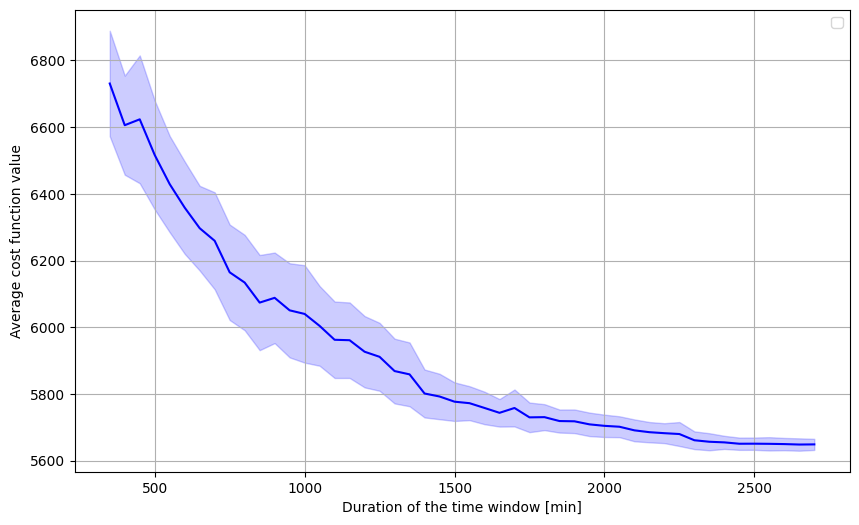

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


averages = []
conf_intervals = []

for sublist in cost:
    numeric_values = [x for x in sublist if isinstance(x, (int, float))]
    if numeric_values:
        avg = np.mean(numeric_values)
        std_dev = np.std(numeric_values, ddof=1)
        n = len(numeric_values)
        df = n - 1

        t_value = stats.t.ppf(1 - 0.025, df)

        ci = (avg - t_value * std_dev / np.sqrt(n),
              avg + t_value * std_dev / np.sqrt(n))
    else:
        avg = 0
        ci = (0, 0)
    averages.append(avg)
    conf_intervals.append(ci)

lower_bounds = [ci[0] for ci in conf_intervals]
upper_bounds = [ci[1] for ci in conf_intervals]

plt.figure(figsize=(10, 6))
plt.plot(time_window_time_list[6:], averages[6:], linestyle='-', color='blue')
plt.fill_between(time_window_time_list[6:], lower_bounds[6:], upper_bounds[6:], color='blue', alpha=0.2)
plt.xlabel('Duration of the time window [min]')
plt.ylabel('Average cost function value')
plt.grid(True)
plt.legend()
plt.show()
plt.show()


In [ ]:
counts = [lst.count("INFEISABLE") for lst in cost]
counts.sort(reverse=True)
for i, count in enumerate(counts):
    print(f"Lista {50 + i*50}: {count} razy INFEISABLE")

Lista 50: 20 razy INFEISABLE
Lista 100: 19 razy INFEISABLE
Lista 150: 17 razy INFEISABLE
Lista 200: 14 razy INFEISABLE
Lista 250: 12 razy INFEISABLE
Lista 300: 7 razy INFEISABLE
Lista 350: 6 razy INFEISABLE
Lista 400: 4 razy INFEISABLE
Lista 450: 3 razy INFEISABLE
Lista 500: 1 razy INFEISABLE
Lista 550: 1 razy INFEISABLE
Lista 600: 0 razy INFEISABLE
Lista 650: 0 razy INFEISABLE
Lista 700: 0 razy INFEISABLE
Lista 750: 0 razy INFEISABLE
Lista 800: 0 razy INFEISABLE
Lista 850: 0 razy INFEISABLE
Lista 900: 0 razy INFEISABLE
Lista 950: 0 razy INFEISABLE
Lista 1000: 0 razy INFEISABLE
Lista 1050: 0 razy INFEISABLE
Lista 1100: 0 razy INFEISABLE
Lista 1150: 0 razy INFEISABLE
Lista 1200: 0 razy INFEISABLE
Lista 1250: 0 razy INFEISABLE
Lista 1300: 0 razy INFEISABLE
Lista 1350: 0 razy INFEISABLE
Lista 1400: 0 razy INFEISABLE
Lista 1450: 0 razy INFEISABLE
Lista 1500: 0 razy INFEISABLE
Lista 1550: 0 razy INFEISABLE
Lista 1600: 0 razy INFEISABLE
Lista 1650: 0 razy INFEISABLE
Lista 1700: 0 razy INFEIS